In [1]:
import torch
import torchvision
from torchvision.utils import save_image
from torch.nn import functional as F
from tqdm import tqdm

In [2]:
print ('Available devices ', torch.cuda.device_count())

Available devices  1


In [3]:
!mkdir data_faces && wget https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip 

--2023-04-05 22:19:47--  https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.120.24
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.120.24|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1443490838 (1.3G) [application/zip]
Saving to: ‘celeba.zip’

celeba.zip          100%[===================>]   1.34G  19.3MB/s    in 73s     

2023-04-05 22:21:01 (18.7 MB/s) - ‘celeba.zip’ saved [1443490838/1443490838]



In [4]:
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim

from zipfile import ZipFile
with ZipFile("./celeba.zip", "r") as zipobj:
    zipobj.extractall("celeba_gan")

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

BS=256

transformation = transforms.Compose([
                                   transforms.Resize(64),
                                   transforms.CenterCrop(64),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                               ])
train_data_raw=datasets.ImageFolder(root='./celeba_gan', transform=transformation)



train_data=DataLoader(train_data_raw,batch_size=BS,shuffle=True)

torch.Size([256, 3, 64, 64])


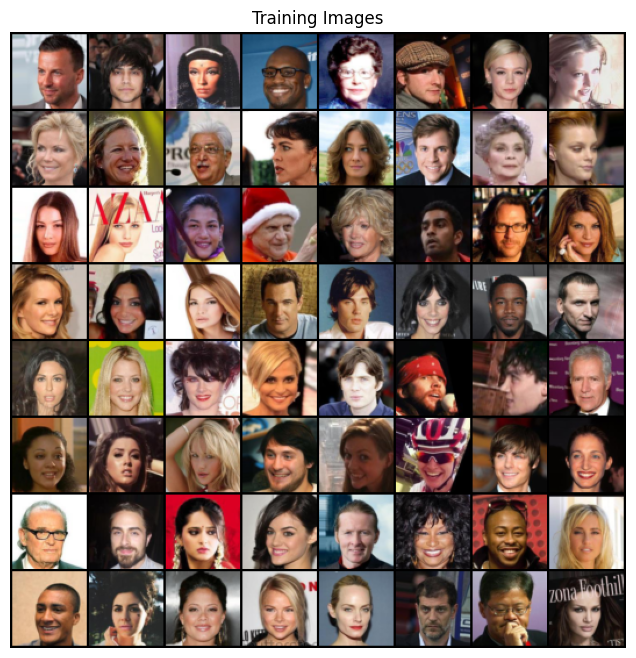

In [7]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
real_batch = next(iter(train_data))
print(real_batch[0].shape)
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

architecture from https://arxiv.org/pdf/1610.00291.pdf 

In [8]:


def calc_loss(x_hat, x, mu, var, loss_fcn):
    CE_loss=loss_fcn(x_hat,x)
    KL_diverge=-0.5 * torch.sum(1 + var - mu.pow(2) - var.exp())
    return CE_loss+KL_diverge

In [9]:
import zipfile
import torch.nn as nn
from torch.autograd import Variable
class VAE(nn.Module):
    def __init__(self):
        super(VAE,self).__init__()
        self.device=device
        #encoder layers
        self.encoderNet=nn.Sequential(
            #block 1
            nn.Conv2d(3, 32, kernel_size=(4,4), stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, True),
            #block 2
            nn.Conv2d(32, 64, kernel_size=(4,4), stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, True),

            #block 3
            nn.Conv2d(64, 128, kernel_size=(4,4), stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, True),

            #block 3
            nn.Conv2d(128, 256, kernel_size=(4,4), stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, True),

        )
        #mu
        self.fc1=nn.Linear(256*4*4,100)
        #log_var
        self.fc2=nn.Linear(256*4*4,100)
        
  


        #decoder layers
        self.decoderNet=nn.Sequential(
            nn.Linear(100, 4096),
            nn.Unflatten(1, (256, 4, 4)),

            #block 1
            nn.Upsample(scale_factor=2),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128, 1.e-3),
            nn.LeakyReLU(),

            #block 2
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64, 1.e-3),
            nn.LeakyReLU(),
            
            #block 3
            nn.Upsample(scale_factor=2),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32,1.e-3),
            nn.LeakyReLU(),

            #final
            nn.Upsample(scale_factor=2),
            nn.Conv2d(32, 3, kernel_size=3, padding=1),

        )





    def encode(self,x):
        x=self.encoderNet(x)
        x=x.view(x.size(0), 256*4*4)
        mu=self.fc1(x)
        var=self.fc2(x)
        return mu, var
    
    def decode(self,z):
        return self.decoderNet(z)
    
    def sample(self, mu, var):
        deviation=torch.exp(0.5*var)
        epsilon = torch.FloatTensor(deviation.size()).normal_().to(self.device)
        epsilon = Variable(epsilon)
        sample=torch.mul(deviation,epsilon).add_(mu) 
        return sample
    
    def forward(self,x):
        mu, var=self.encode(x)
        z=self.sample(mu=mu,var=var)
        value=self.decode(z)
        return value,mu,var

vae=VAE()
print(vae)





from google.colab import drive
drive.mount('/content/gdrive')


path = F"/content/gdrive/My Drive/celebVae"
vae.load_state_dict(torch.load(path))



VAE(
  (encoderNet): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (fc1): Linear(in_features=4096, out_features=100, bias=True)
  (fc2): Linear(in_feature

<All keys matched successfully>

In [10]:
def train_step_VAE(model: torch.nn.Module,
                   loss_fcn: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader, 
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()
    
    
    # Setup train loss and train accuracy values
    train_loss=0
    
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):

        
        optimizer.zero_grad()
        X=X.to(device)
        
        # 1. calc real loss
        y_pred, mu, var = model(X)
        
        loss = calc_loss(y_pred, X, mu, var, loss_fcn)
       

        # 3. Loss backward
        loss.backward()
        
       
        # 4. Optimizer step for disc
        optimizer.step()
        train_loss+=loss.item()
        
       
        

        
       

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    
    path = F"/content/gdrive/My Drive/celebVae" 
    torch.save(vae.state_dict(), path)
    

    return train_loss

In [11]:
# 1. Take in various parameters required for training and test steps
def train_VAE(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,  
          epochs: int = 5):
  
    model=model.to(device)
    model.device=device
    loss_fcn=nn.MSELoss(reduction='sum') 
    optimizer=optim.Adam(model.parameters(), lr=0.0005)

    
    
    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": [],
        "sample_images":[]
    }
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss = train_step_VAE(model=model,
                                           dataloader=train_dataloader,
                                           loss_fcn=loss_fcn,
                                           optimizer=optimizer)
        
        test_loss=0
     
        
        #with torch.no_grad():
            
        #    model.eval()
         #   for batch, (X, y) in enumerate(test_dataloader):
          #      X=X.to(device)
           #    
            #    y_pred, mu, var = model(X)
        
             #   loss = calc_loss(y_pred, X, mu, var, loss_fcn)
             #   test_loss+=loss.item()
        
        #test_loss=test_loss/len(test_dataloader)
        
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            #f"test_accuracy: {test_loss:.4f} | "
        )

        
    # 6. Return the filled results at the end of the epochs
    model=model.to('cpu')
    model.device='cpu'
    return results

In [12]:
NUM_EPOCHS = 20





# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model_0 
model_results = train_VAE(model=vae, 
                        train_dataloader=train_data,
                        epochs=NUM_EPOCHS)

path = F"/content/gdrive/My Drive/celebVae" 
torch.save(vae.state_dict(), path)
# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

 10%|█         | 1/10 [06:40<1:00:03, 400.43s/it]

Epoch: 1 | train_loss: 106787.1749 | 


 20%|██        | 2/10 [13:05<52:11, 391.47s/it]  

Epoch: 2 | train_loss: 106708.0607 | 


 30%|███       | 3/10 [19:22<44:54, 384.90s/it]

Epoch: 3 | train_loss: 106692.6248 | 


 40%|████      | 4/10 [25:39<38:09, 381.63s/it]

Epoch: 4 | train_loss: 106644.5282 | 


 50%|█████     | 5/10 [31:55<31:39, 379.83s/it]

Epoch: 5 | train_loss: 106616.8618 | 


 60%|██████    | 6/10 [38:19<25:23, 380.96s/it]

Epoch: 6 | train_loss: 106615.5702 | 


 70%|███████   | 7/10 [44:37<19:00, 380.07s/it]

Epoch: 7 | train_loss: 106630.4431 | 


 80%|████████  | 8/10 [50:53<12:37, 378.92s/it]

Epoch: 8 | train_loss: 106527.8402 | 


 90%|█████████ | 9/10 [57:11<06:18, 378.63s/it]

Epoch: 9 | train_loss: 106487.6246 | 


100%|██████████| 10/10 [1:03:27<00:00, 380.77s/it]

Epoch: 10 | train_loss: 106516.3133 | 
Total training time: 3807.817 seconds


In [13]:
!mkdir vae_samples

In [14]:
vae=vae.to('cpu')
vae.device='cpu'
with torch.no_grad():
    z = torch.randn(64, 100)
    sample = vae.decode(z)
    
    save_image((sample.view(64, 3, 64, 64)+1)/2, './vae_samples/sample_' + '.png')

In [15]:

from PIL import Image
import os
import numpy as np

def loadImage(folder_path, example_ind, INPUT_DIMS=(3,64,64)):
    image_path = os.path.join(folder_path, str(example_ind).zfill(6)+".jpg")
    pil_image = Image.open(image_path)
    image=transformation(pil_image)
    return image
     

In [16]:
def morphBetweenImages(example_ind1, example_ind2, VAE, images_path, num_of_morphs):
    with torch.no_grad():
      # load images
      img1 = loadImage(images_path, example_ind1).view(1,3,64,64)
      img2 = loadImage(images_path, example_ind2).view(1,3,64,64)
      print(img2.shape)
      # define alpha 
      alpha = np.linspace(0,1,num_of_morphs)
      # get latent spaces
      mu, var=VAE.encode(img1)
      z1=VAE.sample(mu=mu,var=var)
      mu, var=VAE.encode(img2)
      z2=VAE.sample(mu=mu,var=var)

      # morph and plot
      fig = plt.figure(figsize=(30,30))
      ax = fig.add_subplot(1, num_of_morphs+2, 1)
      ax.imshow(((img1+1)/2).view(3,64,64).permute(1, 2, 0).squeeze())
      ax.axis('off')
      ax.set_title(loc='center', label='original image 1',fontsize=10)
      for i in range(num_of_morphs):
          z = z1*(1-alpha[i]) + z2*alpha[i]
          new_img = VAE.decode(z)
          ax = fig.add_subplot(1, num_of_morphs+2, i+2)
          ax.imshow(((new_img+1)/2).view(3,64,64).permute(1, 2, 0).squeeze())
          ax.axis('off')
          ax.set_title(loc='center', label='alpha={:.2f}'.format(alpha[i]))
      ax = fig.add_subplot(1, num_of_morphs+2, num_of_morphs+2)
      ax.imshow(((img2+1)/2).view(3,64,64).permute(1, 2, 0).squeeze())
      ax.axis('off')
      ax.set_title(loc='center', label='original image 2',fontsize=10)
    return

torch.Size([1, 3, 64, 64])


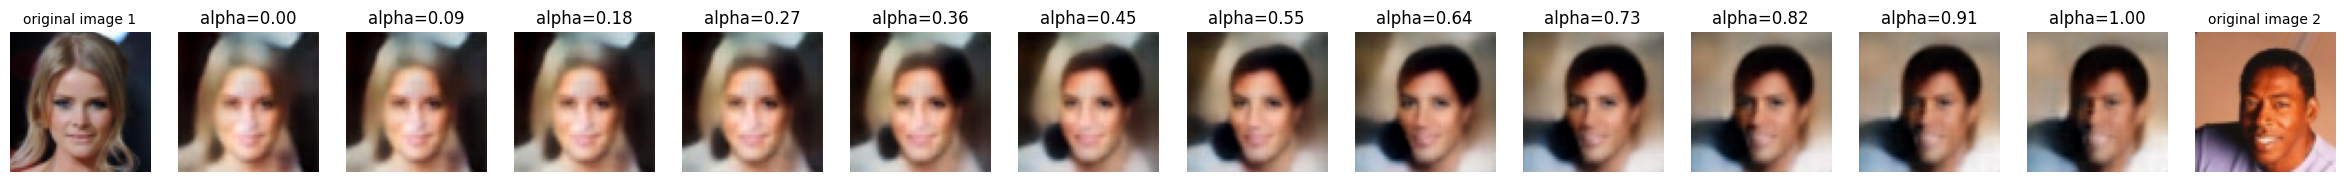

In [17]:

example_ind1 = 10
example_ind2 = 2000
num_of_morphs = 12
morphBetweenImages(example_ind1,example_ind2,vae,"celeba_gan/img_align_celeba",num_of_morphs)

In [19]:
labels = pd.read_csv('./list_attr_celeba.csv')
labels.head(11)

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1
5,000006.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,1,-1,1,-1,-1,1
6,000007.jpg,1,-1,1,1,-1,-1,1,1,1,...,-1,-1,1,-1,-1,-1,-1,-1,-1,1
7,000008.jpg,1,1,-1,1,-1,-1,1,-1,1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,1
8,000009.jpg,-1,1,1,-1,-1,1,1,-1,-1,...,-1,1,-1,-1,1,-1,1,-1,-1,1
9,000010.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,1,-1,-1,1,-1,-1,1


In [31]:
# Separate the images into those that have the attribute, and those that don't


attribute_mask = []
non_attribute_mask=[]
for index, row in labels.iterrows():
  if row["Eyeglasses"]==1:
    attribute_mask.append(index)
  else:
    non_attribute_mask.append(index)


print(attribute_mask)



[52, 92, 118, 143, 151, 153, 187, 188, 192, 201, 228, 233, 236, 263, 265, 274, 275, 309, 329, 334, 349, 372, 374, 382, 391, 443, 446, 450, 481, 483, 499, 510, 519, 574, 580, 607, 618, 623, 627, 645, 672, 674, 675, 682, 686, 704, 709, 719, 725, 759, 777, 787, 797, 814, 901, 903, 906, 910, 925, 929, 934, 937, 943, 950, 957, 1027, 1032, 1051, 1062, 1095, 1100, 1108, 1162, 1165, 1183, 1186, 1193, 1214, 1223, 1240, 1302, 1324, 1350, 1351, 1399, 1400, 1434, 1440, 1443, 1456, 1469, 1470, 1505, 1510, 1528, 1553, 1554, 1556, 1558, 1597, 1605, 1607, 1612, 1615, 1651, 1674, 1689, 1702, 1720, 1727, 1735, 1740, 1753, 1754, 1755, 1793, 1798, 1830, 1894, 1916, 1929, 1935, 1945, 1985, 2002, 2003, 2008, 2030, 2049, 2057, 2060, 2074, 2077, 2110, 2123, 2124, 2131, 2133, 2134, 2144, 2209, 2226, 2231, 2242, 2275, 2294, 2347, 2365, 2393, 2425, 2434, 2460, 2475, 2476, 2481, 2488, 2504, 2514, 2546, 2586, 2598, 2609, 2612, 2614, 2630, 2634, 2643, 2645, 2663, 2678, 2681, 2687, 2696, 2707, 2728, 2739, 2747, 2757

torch.Size([256, 3, 64, 64])


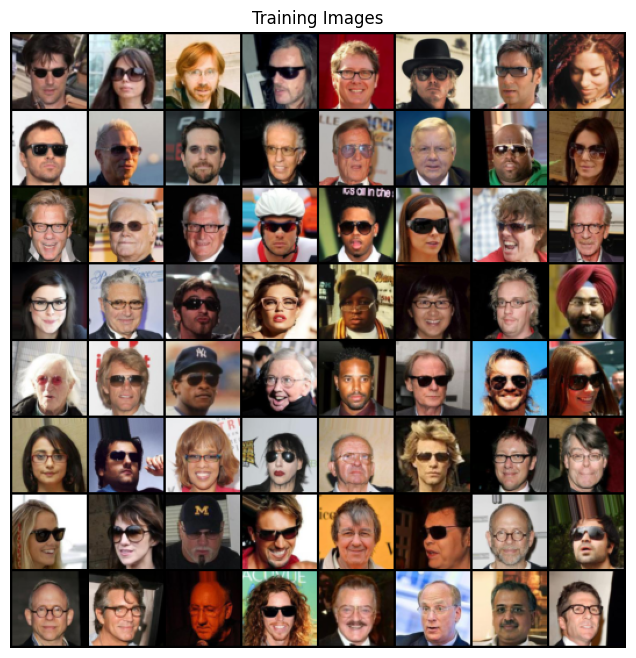

In [32]:
attribute_images=DataLoader(torch.utils.data.Subset(train_data_raw, attribute_mask),batch_size=256)
non_attribute_images=DataLoader(torch.utils.data.Subset(train_data_raw, non_attribute_mask), batch_size=256)

real_batch = next(iter(attribute_images))
print(real_batch[0].shape)
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [33]:
vae.eval()
vae=vae.to('cuda')
vae.device='cuda'
att_z=[]
non_att_z=[]
with torch.no_grad():
  for batch, (X, y) in enumerate(attribute_images):
    mu, var =vae.encode(X.to('cuda'))
    z=vae.sample(mu,var)
    att_z.append(z.to('cpu'))
  for batch, (X, y) in enumerate(non_attribute_images):
    mu, var=vae.encode(X.to('cuda'))
    z=vae.sample(mu,var)
    non_att_z.append(z.to('cpu'))
  


In [34]:
a_z=torch.cat((att_z))
n_a_z=torch.cat((non_att_z))

print(a_z.shape)
att_z_val=a_z.mean(dim=0, keepdim=True)
non_att_z_val=n_a_z.mean(dim=0, keepdim=True)

torch.Size([13193, 100])


In [35]:
value_of_att=att_z_val-non_att_z_val
value_of_att.shape

torch.Size([1, 100])

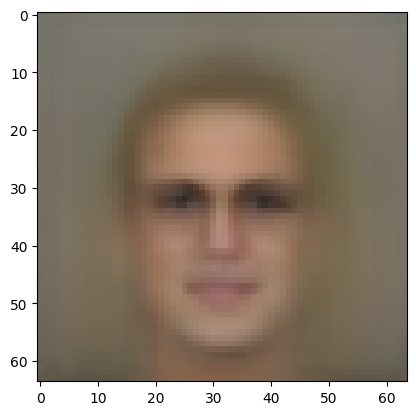

In [36]:
vae=vae.to('cpu')
vae.device='cpu'
decoded_att=vae.decode(value_of_att)
plt.imshow( (((decoded_att+1)/2).detach().view(3,64,64)).permute(1, 2, 0).squeeze()  )

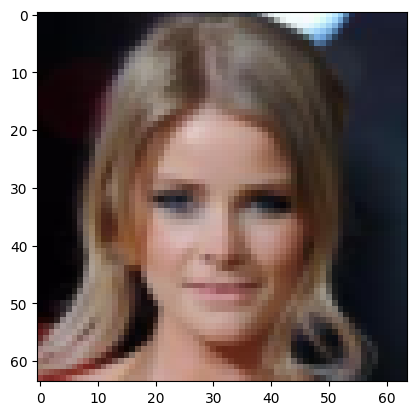

In [37]:
img1 = loadImage("celeba_gan/img_align_celeba", example_ind1).view(1,3,64,64)
plt.imshow(((img1+1)/2).view(3,64,64).permute(1, 2, 0))


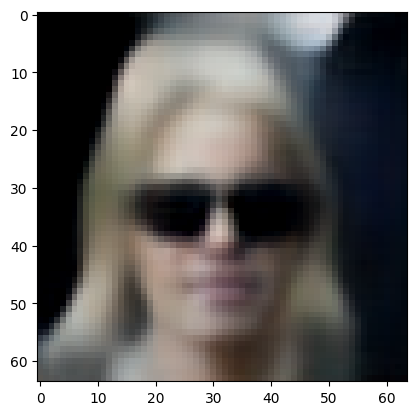

In [43]:
mu, var=vae.encode(img1)
z2=vae.sample(mu=mu,var=var)+(2.5*value_of_att)
im=vae.decode(z2).detach()
plt.imshow(((im+1)/2).view(3,64,64).permute(1, 2, 0))

In [67]:
import random
n_examples = 7
sampled_inx = random.choices(non_attribute_mask, k=n_examples)
sample_images_without_attribute = [loadImage("celeba_gan/img_align_celeba", ind+1).view(1,3,64,64) for ind in sampled_inx]
zs=[]
zs2=[]
for img in sample_images_without_attribute:
  mu, var = vae.encode(img)
  zs.append(vae.sample(mu, var))
zs2=[z++(2.5*value_of_att) for z in zs]

sample_images_reconstructions=[]
modified_reconstructions=[]
for ind in range(len(zs)):
  sample_images_reconstructions.append(vae.decode(zs[ind]).detach())
  modified_reconstructions.append(vae.decode(zs2[ind]).detach())



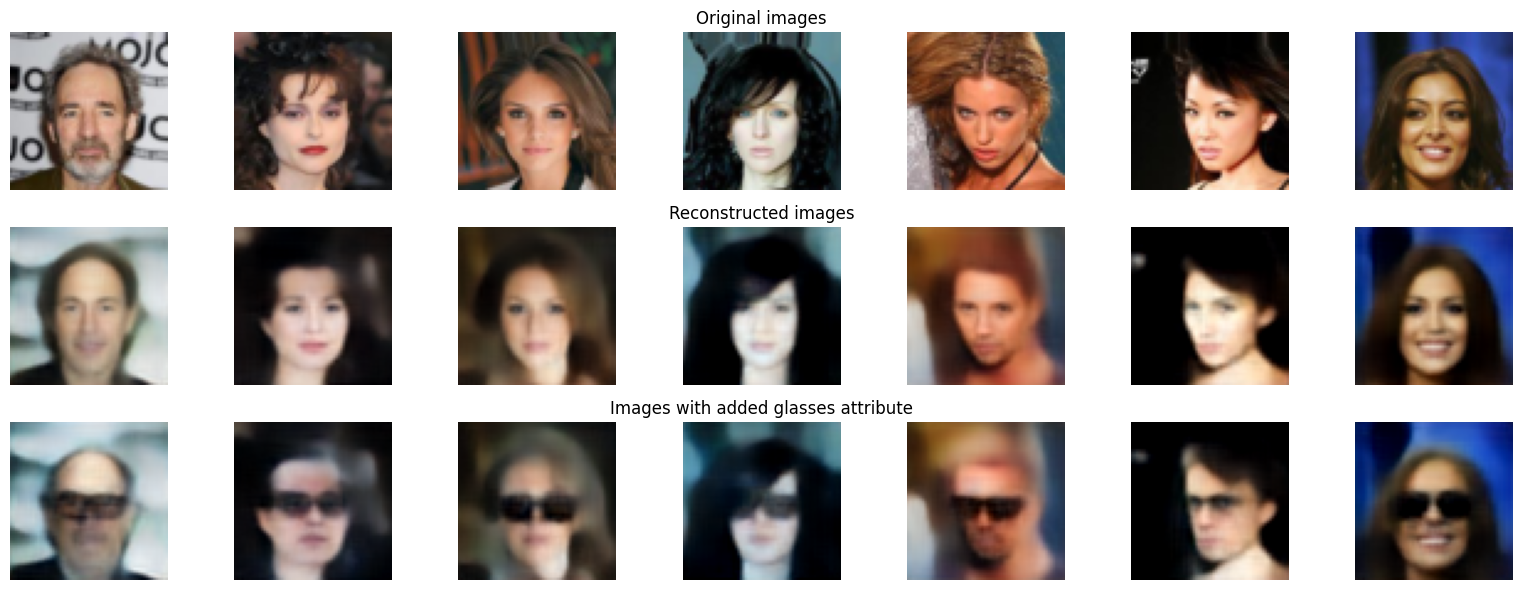

In [68]:
f, axs = plt.subplots(3, n_examples, figsize=(16, 6))
axs[0, n_examples // 2].set_title("Original images")
axs[1, n_examples // 2].set_title("Reconstructed images")
axs[2, n_examples // 2].set_title("Images with added glasses attribute")
for j in range(n_examples):
    axs[0, j].imshow(((sample_images_without_attribute[j]+1)/2).view(3,64,64).permute(1, 2, 0))
    axs[1, j].imshow(((sample_images_reconstructions[j]+1)/2).view(3,64,64).permute(1, 2, 0))
    axs[2, j].imshow(((modified_reconstructions[j]+1)/2).view(3,64,64).permute(1, 2, 0))
    for ax in axs[:, j]: ax.axis('off')
    
plt.tight_layout();